
=== PERCOLATION ANALYSIS: Barcelona ===
Impact of Messi red card: 3.59% efficiency drop

=== PERCOLATION CURVE: Barcelona ===


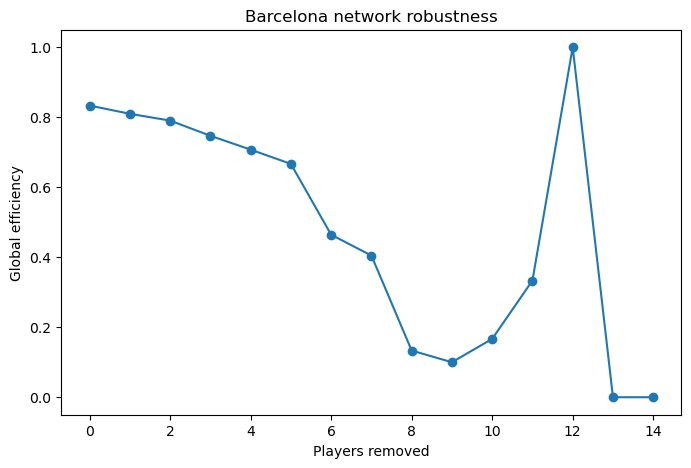


=== DIFFUSION SIMULATION: Barcelona ===
Top ball-occupancy players:
Xavi          0.1914
Iniesta       0.1652
Messi         0.1604
Dani Alves    0.0980
Busquets      0.0866
dtype: float64

=== DIFFUSION SIMULATION: Barcelona (No Messi) ===
Top ball-occupancy players:
Xavi          0.2080
Iniesta       0.1810
Dani Alves    0.1216
Busquets      0.1162
Abidal        0.0782
dtype: float64

=== DEFENSIVE LOAD: Manchester United vs Messi ===
Primary defenders involved:
player
Javier Hernández Balcázar    15
Park                         15
Rooney                       14
dtype: int64

=== INTERDEPENDENT NETWORK EFFECT (BARCA → MAN UTD) ===
Baseline efficiency: 0.9103
Post-Messi efficiency: 0.9103
Efficiency change: 0.00%
Affected defenders: ['Park', 'Javier Hernández Balcázar', 'Rooney', 'Giggs', 'Luis Antonio Valencia Mosquera']

=== GOAL NETWORK: Barcelona, minute 54 ===
Players involved: ['Abidal', 'Piqué', 'Iniesta']
Centralization proxy: 0.33


In [171]:
#Final code-Teferi 

import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ast import literal_eval
from matplotlib.patches import Circle, Rectangle

# --- PATH SETUP ---
RAW_DATA_PATH = "barca_manutd_2011_events.csv"
PROCESSED_DATA_DIR = "./data/processed/"
FIGURES_DIR = "./results/figures/"

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# --- DATA LOADING & MAPPING ---
df = pd.read_csv(RAW_DATA_PATH)
df["location"] = df["location"].apply(
    lambda x: literal_eval(str(x)) if pd.notnull(x) else None
)

player_name_map = {
    "Víctor Valdés Arribas": "Valdés", "Daniel Alves da Silva": "Dani Alves",
    "Gerard Piqué Bernabéu": "Piqué", "Javier Alejandro Mascherano": "Mascherano",
    "Eric-Sylvain Bilal Abidal": "Abidal", "Sergio Busquets i Burgos": "Busquets",
    "Xavier Hernández Creus": "Xavi", "Andrés Iniesta Luján": "Iniesta",
    "Pedro Eliezer Rodríguez Ledesma": "Pedro",
    "Lionel Andrés Messi Cuccittini": "Messi",
    "David Villa Sánchez": "Villa", "Carles Puyol i Saforcada": "Puyol",
    "Edwin van der Sar": "Van der Sar", "Rio Ferdinand": "Ferdinand",
    "Nemanja Vidić": "Vidić", "Patrice Evra": "Evra",
    "Michael Carrick": "Carrick", "Ryan Giggs": "Giggs",
    "Ji-Sung Park": "Park", "Wayne Mark Rooney": "Rooney"
}

df["player"] = df["player"].map(player_name_map).fillna(df["player"])
df["pass_recipient"] = df["pass_recipient"].map(player_name_map).fillna(df["pass_recipient"])

# --- HELPER FUNCTIONS ---
def build_graph_from_df(edges_df, directed=True):
    G = nx.DiGraph() if directed else nx.Graph()
    for _, row in edges_df.iterrows():
        G.add_edge(row["player"], row["pass_recipient"], weight=row["pass_count"])
    return G

def get_network_data(df, team, start_min, end_min):
    mask = (df["team"] == team) & (df["minute"] >= start_min) & (df["minute"] < end_min)
    df_passes = df[mask & (df["type"] == "Pass") & (df["pass_outcome"].isnull())].copy()
    if df_passes.empty:
        return None, None
    pass_between = df_passes.groupby(["player", "pass_recipient"]).size().reset_index(name="pass_count")
    return df_passes, pass_between

# --- TASK 1: SINGLE-NODE PERCOLATION ---
def run_percolation_analysis(df, team, player_to_remove):
    print(f"\n=== PERCOLATION ANALYSIS: {team} ===")
    _, edges = get_network_data(df, team, 0, 95)
    G = build_graph_from_df(edges, directed=False)
    orig_eff = nx.global_efficiency(G)
    G.remove_node(player_to_remove)
    new_eff = nx.global_efficiency(G)
    drop = ((orig_eff - new_eff) / orig_eff) * 100
    print(f"Impact of {player_to_remove} red card: {drop:.2f}% efficiency drop")

# --- TASK 2: PERCOLATION CURVE ---
def plot_percolation_curve(df, team):
    print(f"\n=== PERCOLATION CURVE: {team} ===")
    _, edges = get_network_data(df, team, 0, 95)
    G = build_graph_from_df(edges, directed=False)

    order = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    effs = [nx.global_efficiency(G)]
    Gt = G.copy()
    for n, _ in order:
        Gt.remove_node(n)
        effs.append(nx.global_efficiency(Gt))

    plt.figure(figsize=(8, 5))
    plt.plot(effs, marker="o")
    plt.xlabel("Players removed")
    plt.ylabel("Global efficiency")
    plt.title(f"{team} network robustness")
    plt.show()

# --- TASK 3: DIFFUSION (RANDOM WALK) ---
def run_diffusion_simulation(df, team, removed_player=None):
    label = f"{team} (No {removed_player})" if removed_player else team
    print(f"\n=== DIFFUSION SIMULATION: {label} ===")

    _, edges = get_network_data(df, team, 0, 95)
    G = build_graph_from_df(edges, directed=True)
    if removed_player:
        G.remove_node(removed_player)

    nodes = list(G.nodes())
    A = nx.to_numpy_array(G, nodelist=nodes, weight="weight")
    P = np.nan_to_num(A / A.sum(axis=1, keepdims=True))

    pos = np.random.randint(len(nodes))
    visits = np.zeros(len(nodes))
    for _ in range(5000):
        pos = np.random.choice(len(nodes), p=P[pos])
        visits[pos] += 1

    occ = pd.Series(visits / visits.sum(), index=nodes).sort_values(ascending=False)
    print("Top ball-occupancy players:")
    print(occ.head(5))

# --- TASK 4: DEFENSIVE RELIEF ---
def analyze_opponent_relief(df, team_defense, target_player):
    print(f"\n=== DEFENSIVE LOAD: {team_defense} vs {target_player} ===")
    locs = df[(df["player"] == target_player) & (df["location"].notnull())]["location"]
    mx, my = np.mean([l[0] for l in locs]), np.mean([l[1] for l in locs])

    def_df = df[
        (df["team"] == team_defense) &
        (df["type"].isin(["Pressure", "Duel", "Interception"])) &
        (df["location"].notnull())
    ].copy()

    def_df["dist"] = def_df["location"].apply(
        lambda l: np.sqrt((l[0] - mx)**2 + (l[1] - my)**2)
    )

    relief = def_df[def_df["dist"] < 25].groupby("player").size().sort_values(ascending=False)
    print("Primary defenders involved:")
    print(relief.head(3))

# --- 🔥 TASK 5: INTERDEPENDENT NETWORK RESPONSE ---
def interdependent_network_effect(df, removed_player="Messi"):
    print("\n=== INTERDEPENDENT NETWORK EFFECT (BARCA → MAN UTD) ===")

    locs = df[(df["player"] == removed_player) & (df["location"].notnull())]["location"]
    mx, my = np.mean([l[0] for l in locs]), np.mean([l[1] for l in locs])

    def_df = df[
        (df["team"] == "Manchester United") &
        (df["type"].isin(["Pressure", "Duel", "Interception"])) &
        (df["location"].notnull())
    ].copy()

    def_df["dist"] = def_df["location"].apply(
        lambda l: np.sqrt((l[0] - mx)**2 + (l[1] - my)**2)
    )

    affected = def_df[def_df["dist"] < 25]["player"].value_counts().index.tolist()

    _, edges = get_network_data(df, "Manchester United", 0, 95)
    G = build_graph_from_df(edges, directed=False)

    base_eff = nx.global_efficiency(G)

    for u, v in G.edges():
        if u in affected or v in affected:
            G[u][v]["weight"] *= 0.7

    new_eff = nx.global_efficiency(G)
    delta = ((new_eff - base_eff) / base_eff) * 100

    print(f"Baseline efficiency: {base_eff:.4f}")
    print(f"Post-Messi efficiency: {new_eff:.4f}")
    print(f"Efficiency change: {delta:.2f}%")
    print("Affected defenders:", affected[:5])

# --- TASK 6: GOAL CHAIN ---
def analyze_goal_chain(df, minute, team):
    print(f"\n=== GOAL NETWORK: {team}, minute {minute} ===")
    mask = (df["team"] == team) & (df["minute"] == minute) & (df["type"] == "Pass")
    chain = df[mask].groupby(["player", "pass_recipient"]).size().reset_index(name="pass_count")
    G = build_graph_from_df(chain)
    print("Players involved:", list(G.nodes()))
    print(f"Centralization proxy: {max(dict(G.in_degree()).values()) / len(G.nodes()):.2f}")

# --- EXECUTION ---
try:
    run_percolation_analysis(df, "Barcelona", "Messi")
    plot_percolation_curve(df, "Barcelona")
    run_diffusion_simulation(df, "Barcelona")
    run_diffusion_simulation(df, "Barcelona", removed_player="Messi")
    analyze_opponent_relief(df, "Manchester United", "Messi")
    interdependent_network_effect(df, "Messi")
    analyze_goal_chain(df, 54, "Barcelona")
except Exception as e:
    print(f"Analysis Error: {e}")
